In [1]:
#Import libraries
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
from tqdm import tqdm

# Set display option to prevent scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
#Load data
df = pd.read_parquet('parsed_data/albany_assessment_2023_and_2024.parquet', engine='pyarrow')
df.head()

,parcel_num,address_2023,property_type_code_2023,county_tax_2023,city_tax_2023,full_market_value_2023,school_tax_2023,address_2024,property_type_code_2024,county_tax_2024,city_tax_2024,full_market_value_2024,school_tax_2024
0,76.22-3-40,Rear 335.5 Myrtle Ave,311,"1,400","1,400","1,977","1,400",Rear 335.5 Myrtle Ave,311,"3,000","3,000","3,000","3,000"
1,75.36-2-79,3 Academy Rd \n \n,210,"205,000","205,000","289,425","205,000",3 Academy Rd \n \n,210,"378,000","378,000","378,000","378,000"
2,75.36-2-78,5 Academy Rd \n \n,210,"162,000","90,000","254,130","97,110",5 Academy Rd \n \n,210,"149,000","149,000","298,000","65,000"
3,75.36-2-77,7 Academy Rd \n \n,210,"237,000","237,000","334,604","237,000",7 Academy Rd \n \n,210,"334,000","334,000","334,000","334,000"
4,75.36-2-76,9 Academy Rd \n \n,210,"192,000","192,000","271,072","168,080",9 Academy Rd \n \n,210,"359,000","359,000","359,000","329,000"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28963 entries, 0 to 28962
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   parcel_num               28963 non-null  object
 1   address_2023             28963 non-null  object
 2   property_type_code_2023  28963 non-null  object
 3   county_tax_2023          28963 non-null  object
 4   city_tax_2023            28963 non-null  object
 5   full_market_value_2023   28963 non-null  object
 6   school_tax_2023          28963 non-null  object
 7   address_2024             28963 non-null  object
 8   property_type_code_2024  28963 non-null  object
 9   county_tax_2024          28963 non-null  object
 10  city_tax_2024            28963 non-null  object
 11  full_market_value_2024   28963 non-null  object
 12  school_tax_2024          28963 non-null  object
dtypes: object(13)
memory usage: 2.9+ MB


# Handling Missing Data

* No missing values were found. However, the parsing script employed adding an empty string when a value was not found by the regex pattern.
* There are many missing values for addresses. However, the 2023 column has less missing values. We will drop the 2024 column and drop observations that have a missing value in the 2023 column.
* There are missing values for the full market value column. We'll drop observations based on both 2023 and 2024 values.
* 'property_type_code_2023' has 350 empty string values. Whereas property_type_code_2024 has 351 empty string values. They'll be filled in with a zero in its stead.

In [4]:
#check for missing values in each column
missing_values = df.isnull().sum()

print("\nMissing Values in Each Column:")
print(missing_values)


Missing Values in Each Column:
parcel_num                 0
address_2023               0
property_type_code_2023    0
county_tax_2023            0
city_tax_2023              0
full_market_value_2023     0
school_tax_2023            0
address_2024               0
property_type_code_2024    0
county_tax_2024            0
city_tax_2024              0
full_market_value_2024     0
school_tax_2024            0
dtype: int64


In [5]:
#check for empty strings in each column
empty_string_counts = (df == '').sum()

# Display the count of empty strings
print("\nEmpty Strings in Each Column:")
print(empty_string_counts)


Empty Strings in Each Column:
parcel_num                   0
address_2023                51
property_type_code_2023    411
county_tax_2023              0
city_tax_2023                0
full_market_value_2023      92
school_tax_2023              0
address_2024               543
property_type_code_2024    410
county_tax_2024              0
city_tax_2024                0
full_market_value_2024      91
school_tax_2024              0
dtype: int64


In [6]:
#drop columns
df = df.drop('address_2024', axis=1) #drop 'address_2024' col
df = df[df['address_2023'] != ''] #drop observations that have an empty string in 'address_2023'

empty_string_counts = (df == '').sum()

# Display the count of empty strings
print("\nEmpty Strings in Each Column:")
print(empty_string_counts)


Empty Strings in Each Column:
parcel_num                   0
address_2023                 0
property_type_code_2023    396
county_tax_2023              0
city_tax_2023                0
full_market_value_2023      92
school_tax_2023              0
property_type_code_2024    398
county_tax_2024              0
city_tax_2024                0
full_market_value_2024      89
school_tax_2024              0
dtype: int64


In [7]:
df = df[df['full_market_value_2023'] != ''] #drop observations that have an empty string in 'full_market_value_2023'
df = df[df['full_market_value_2024'] != ''] #drop observations that have an empty string in 'full_market_value_2024'

empty_string_counts = (df == '').sum()

# Display the count of empty strings
print("\nEmpty Strings in Each Column:")
print(empty_string_counts)


Empty Strings in Each Column:
parcel_num                   0
address_2023                 0
property_type_code_2023    350
county_tax_2023              0
city_tax_2023                0
full_market_value_2023       0
school_tax_2023              0
property_type_code_2024    351
county_tax_2024              0
city_tax_2024                0
full_market_value_2024       0
school_tax_2024              0
dtype: int64


In [8]:
#replace empty string with 0

df['property_type_code_2023'] = df['property_type_code_2023'].replace('', '0')
# Replace empty strings with '0'
df['property_type_code_2024'] = df['property_type_code_2024'].replace('', '0')

In [9]:
len(df)

28804

# View Statistical Summary

In [10]:
#coerce values to int
lst_to_coerce = ['county_tax_2023', 'city_tax_2023', 'full_market_value_2023', 'school_tax_2023',
                'county_tax_2024', 'city_tax_2024', 'full_market_value_2024', 'school_tax_2024']
for column in lst_to_coerce:
    print(column)
    df[column] = df[column].str.replace(',', '').astype(int)
print('Done coercing')
summary_stats = df[lst_to_coerce].agg(['min', 'max', 'mean'])

df.describe()

county_tax_2023
city_tax_2023
full_market_value_2023
school_tax_2023
county_tax_2024
city_tax_2024
full_market_value_2024
school_tax_2024
Done coercing


,county_tax_2023,city_tax_2023,full_market_value_2023,school_tax_2023,county_tax_2024,city_tax_2024,full_market_value_2024,school_tax_2024
count,28804.00,28804.00,28804.00,28804.00,28804.00,28804.00,28804.00,28804.00
mean,149827.90,147826.35,287791.29,141909.13,224511.14,223344.94,311197.55,214566.61
std,342623.29,340109.80,695604.42,340447.91,410996.73,409375.10,697753.99,408528.37
min,0.00,0.00,71.00,0.00,0.00,0.00,20.00,0.00
25%,40654.00,39356.25,91769.00,27000.00,82000.00,81000.00,120000.00,61000.00
50%,123000.00,120000.00,196174.00,112013.50,198000.00,198000.00,222000.00,186000.00
75%,181000.00,180000.00,271812.50,173000.00,278000.00,278000.00,297025.00,268000.00
max,9750000.00,9750000.00,9902725.00,9750000.00,9979000.00,9979000.00,9979000.00,9979000.00


# Calculate Tax Deltas (Percent Change)

* Percent change is a mathematical concept used to express relative change in value between two points, for this dataset that is 2023 and 2024. For this study we calculate it for County Tax, School Tax, City Tax, and Full Market Value.  
  
* Percent change is can be caculated with the following formula:

$$
\text{Percentage Change} = \left( \frac{\text{Value in 2024} - \text{Value in 2023}}{\text{Value in 2023}} \right) \times 100
$$

* Full Market value was found to have a median value of 14.94%. However, the distribution is left skewed, meaning that it is not normally distributed and there are frequently higher values to the right side of the median value.
* The median value for county tax value was found to be 60.96% which coincides with the mode value. However, it has a long right tail.
* The median value for city tax value was found to be 60.96% which coincides with the mode value. However, it has a long right tail.
* The median value for school tax value was found to be 63.82%.

In [11]:
#Calculate Rate Decrease/Increase from 2023 to 2024
#compute
df['county_tax_percent_delta'] = ((df['county_tax_2024'] - df['county_tax_2023']) / df['county_tax_2023']) * 100

df['city_tax_percent_delta'] = ((df['city_tax_2024'] - df['city_tax_2023']) / df['city_tax_2023']) * 100

df['full_market_value_percent_delta'] = ((df['full_market_value_2024'] - df['full_market_value_2023']) / df['full_market_value_2023']) * 100

df['school_tax_percent_delta'] = ((df['school_tax_2024'] - df['school_tax_2023']) / df['school_tax_2023']) * 100

In [12]:
df.head(5)

,parcel_num,address_2023,property_type_code_2023,county_tax_2023,city_tax_2023,full_market_value_2023,school_tax_2023,property_type_code_2024,county_tax_2024,city_tax_2024,full_market_value_2024,school_tax_2024,county_tax_percent_delta,city_tax_percent_delta,full_market_value_percent_delta,school_tax_percent_delta
0,76.22-3-40,Rear 335.5 Myrtle Ave,311,1400,1400,1977,1400,311,3000,3000,3000,3000,114.29,114.29,51.75,114.29
1,75.36-2-79,3 Academy Rd \n \n,210,205000,205000,289425,205000,210,378000,378000,378000,378000,84.39,84.39,30.60,84.39
2,75.36-2-78,5 Academy Rd \n \n,210,162000,90000,254130,97110,210,149000,149000,298000,65000,-8.02,65.56,17.26,-33.07
3,75.36-2-77,7 Academy Rd \n \n,210,237000,237000,334604,237000,210,334000,334000,334000,334000,40.93,40.93,-0.18,40.93
4,75.36-2-76,9 Academy Rd \n \n,210,192000,192000,271072,168080,210,359000,359000,359000,329000,86.98,86.98,32.44,95.74


In [13]:
#Statistical summary of deltas
df.filter(like='delta').describe()

C:\Users\Lixander\miniconda3\envs\rapids-24.06\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\Lixander\miniconda3\envs\rapids-24.06\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\Lixander\miniconda3\envs\rapids-24.06\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,county_tax_percent_delta,city_tax_percent_delta,full_market_value_percent_delta,school_tax_percent_delta
count,25820.00,25820.00,28804.00,25657.00
mean,inf,inf,98.00,inf
std,NaN,NaN,1873.70,NaN
min,-100.00,-100.00,-99.89,-100.00
25%,36.90,38.50,-1.57,37.72
50%,60.96,62.00,14.94,63.82
75%,96.95,98.00,41.64,101.67
max,inf,inf,99580.00,inf


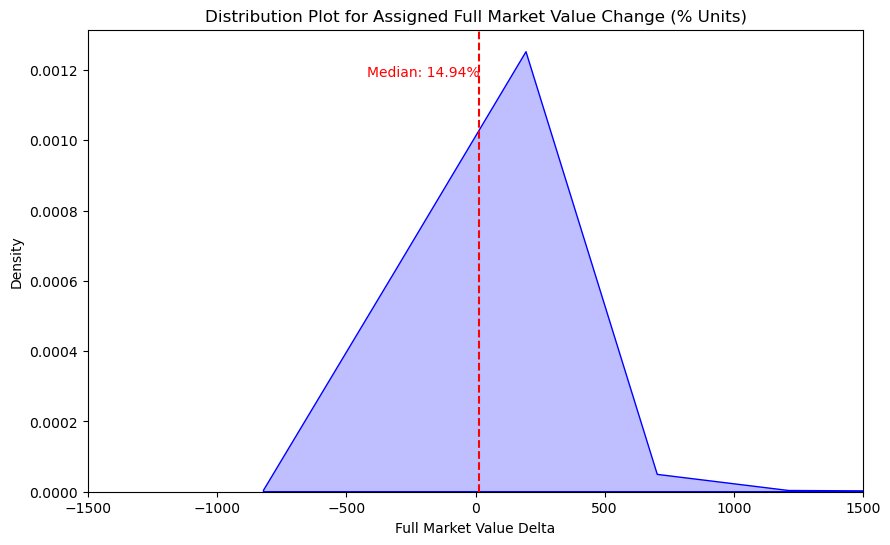

In [14]:
### View Distribution for Full Market Value % Change
median_value_fmv_perc = df['full_market_value_percent_delta'].median() #calc median value

plt.figure(figsize=(10, 6))
sns.kdeplot(df['full_market_value_percent_delta'], fill=True, color='blue')
plt.title(f'Distribution Plot for Assigned Full Market Value Change (% Units)')
plt.xlabel('Full Market Value Delta')
plt.ylabel('Density')
plt.xlim(left=-1500, right=1500) #limit xaxis values
plt.axvline(median_value_fmv_perc, color='red', linestyle='--', label=f'Median: {median_value_fmv_perc:.2f}%') #add median line
plt.text(median_value_fmv_perc, plt.gca().get_ylim()[1] * 0.9, f'Median: {median_value_fmv_perc:.2f}%', color='red', ha='right') #add median line label
plt.show()

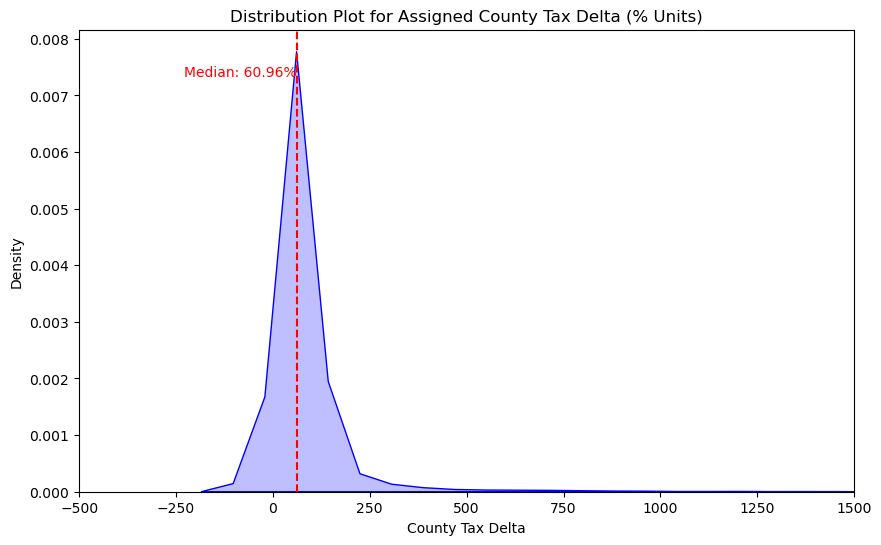

In [15]:
### View Distribution for County Tax Value
median_value_county_tax_perc = df['county_tax_percent_delta'].median() #calc median value

plt.figure(figsize=(10, 6))
sns.kdeplot(df['county_tax_percent_delta'], fill=True, color='blue')
plt.title(f'Distribution Plot for Assigned County Tax Delta (% Units)')
plt.xlabel('County Tax Delta')
plt.ylabel('Density')
plt.xlim(left=-500, right=1500) #limit xaxis values
plt.axvline(median_value_county_tax_perc, color='red', linestyle='--', label=f'Median: {median_value_county_tax_perc:.2f}%') #add median line
plt.text(median_value_county_tax_perc, plt.gca().get_ylim()[1] * 0.9, f'Median: {median_value_county_tax_perc:.2f}%', color='red', ha='right') #add median line label
plt.show()

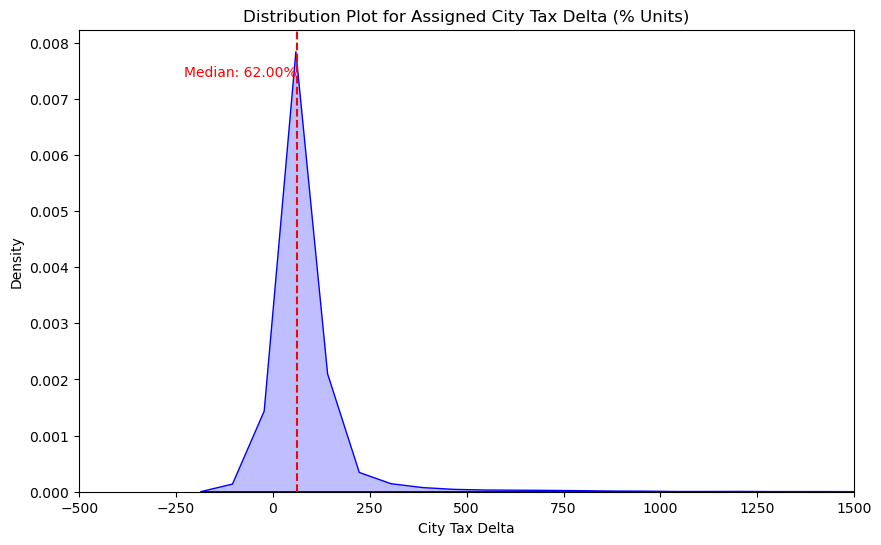

In [16]:
### View Distribution for City Tax Value
median_value_city_tax_perc = df['city_tax_percent_delta'].median() #calc median value

plt.figure(figsize=(10, 6))
sns.kdeplot(df['city_tax_percent_delta'], fill=True, color='blue')
plt.title(f'Distribution Plot for Assigned City Tax Delta (% Units)')
plt.xlabel('City Tax Delta')
plt.ylabel('Density')
plt.xlim(left=-500, right=1500) #limit xaxis values
plt.axvline(median_value_city_tax_perc, color='red', linestyle='--', label=f'Median: {median_value_city_tax_perc:.2f}%') #add median line
plt.text(median_value_city_tax_perc, plt.gca().get_ylim()[1] * 0.9, f'Median: {median_value_city_tax_perc:.2f}%', color='red', ha='right') #add median line label
plt.show()

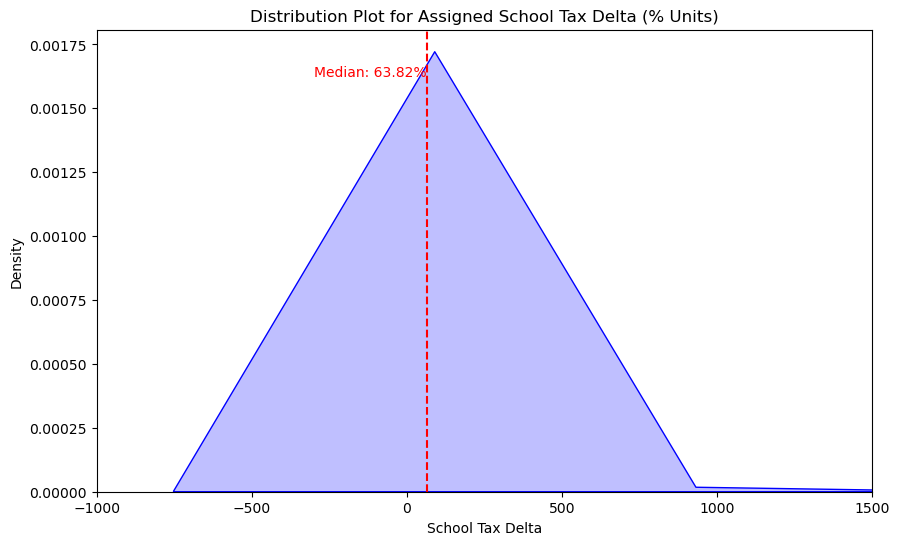

In [17]:
### View Distribution for School Tax Value
median_value_school_tax_perc = df['school_tax_percent_delta'].median() #calc median value

plt.figure(figsize=(10, 6))
sns.kdeplot(df['school_tax_percent_delta'], fill=True, color='blue')
plt.title(f'Distribution Plot for Assigned School Tax Delta (% Units)')
plt.xlabel('School Tax Delta')
plt.ylabel('Density')
plt.xlim(left=-1000, right=1500) #limit xaxis values
plt.axvline(median_value_school_tax_perc, color='red', linestyle='--', label=f'Median: {median_value_school_tax_perc:.2f}%') #add median line
plt.text(median_value_school_tax_perc, plt.gca().get_ylim()[1] * 0.9, f'Median: {median_value_school_tax_perc:.2f}%', color='red', ha='right') #add median line label
plt.show()

# Adding Additonal Geographical Markers
  
To better segment the data, other geographical markers will be added. These include:
* Zip Code
* Neighborhood
* School District
* Low Income area Identifier by zipcode
* Low Income area Identifier by neighborhood
  
To get the additional markers, the address column will need to be cleaned for white space and for the leading words 'Rear' and 'Front'. Next, a geocoding service will be used to extract the additional markers. There are many different services, such as Google Maps, Bing Maps, and OpenStreetMap Nominatim. This script will employ Nominatim which is free of charge as long as each API request are at least 1 second apart.

In [18]:
#Clean addrresses
df['address_2023'] = df['address_2023'].str.replace('\n', '', regex=False).str.strip()
df['address_2023'] = df['address_2023'].str.replace(r'^(Rear|Front)\s+', '', regex=True)
df.head(2)

,parcel_num,address_2023,property_type_code_2023,county_tax_2023,city_tax_2023,full_market_value_2023,school_tax_2023,property_type_code_2024,county_tax_2024,city_tax_2024,full_market_value_2024,school_tax_2024,county_tax_percent_delta,city_tax_percent_delta,full_market_value_percent_delta,school_tax_percent_delta
0,76.22-3-40,335.5 Myrtle Ave,311,1400,1400,1977,1400,311,3000,3000,3000,3000,114.29,114.29,51.75,114.29
1,75.36-2-79,3 Academy Rd,210,205000,205000,289425,205000,210,378000,378000,378000,378000,84.39,84.39,30.60,84.39


In [19]:
%%time

### Add Zipcode Columm
geolocator_coordinates = Nominatim(user_agent="coordinate_extractor")
geolocator_zipcode = Nominatim(user_agent="zip_code_extractor") 

# Initialize lists to store retrieved values
address_geopy = []
zip_codes = []
latitudes = []
longitudes = []
neighborhood_lst = []

def geocode_with_retries(address, retries=3, delay=2, timeout=5):
    for attempt in range(retries):
        try:
            location = geolocator_zipcode.geocode(address, timeout=timeout)
            if location:
                return location
        except GeocoderTimedOut as e:
            print(f"Timeout error for address '{address}': {e}. Retrying {attempt + 1}/{retries}...")
            time.sleep(delay)
        except Exception as e:
            print(f"Error retrieving location for address '{address}': {e}")
            break
    return None

# Iterate over the addresses
for address in tqdm(df['address_2023'], desc="Processing addresses", unit="address"):
    full_address = f"{address}, Albany, NY"
    location1 = geocode_with_retries(full_address)

    # Check if location1 is not None before accessing attributes
    if location1:
        zip_code = location1.raw.get('display_name').split(',')[-2]
        address_geopy.append(location1.address)
        latitude = location1.latitude
        longitude = location1.longitude
        try:
            neighborhood = location1.raw.get('display_name').split(',')[-6].strip()
        except IndexError:
            neighborhood = None
    else:
        zip_code = None
        address_geopy.append(None)
        latitude = None
        longitude = None
        neighborhood = None

    # Append results to lists
    zip_codes.append(zip_code)
    latitudes.append(latitude)
    longitudes.append(longitude)
    neighborhood_lst.append(neighborhood)

    # Throttle API requests
    time.sleep(1)

# Add the data to the DataFrame
df['address_geopy'] = address_geopy
df['zip_code'] = zip_codes
df['latitude'] = latitudes
df['longitude'] = longitudes
df['neighborhood'] = neighborhood_lst

# Save the DataFrame to a parquet file
df.to_parquet('geomarkers/assessment_roll_23_24_with_geomarkers.parquet', index=False)
print("DF with geomarkers saved to assessment_roll_23_24_with_geomarkers.parquet")

df.head()

Processing addresses:  92%|████████████████████████████████████████▌   | 26518/28804 [15:50:03<1:25:54,  2.26s/address]

Error retrieving location for address '1 De La Salle Rd, Albany, NY': HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=1+De+La+Salle+Rd%2C+Albany%2C+NY&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=5)"))


Processing addresses: 100%|██████████████████████████████████████████████| 28804/28804 [16:47:10<00:00,  2.10s/address]

DF with geomarkers saved to assessment_roll_23_24_with_geomarkers.parquet
CPU times: total: 1min 4s
Wall time: 16h 47min 11s


,parcel_num,address_2023,property_type_code_2023,county_tax_2023,city_tax_2023,full_market_value_2023,school_tax_2023,property_type_code_2024,county_tax_2024,city_tax_2024,...,school_tax_2024,county_tax_percent_delta,city_tax_percent_delta,full_market_value_percent_delta,school_tax_percent_delta,address_geopy,zip_code,latitude,longitude,neighborhood
0,76.22-3-40,335.5 Myrtle Ave,311,1400,1400,1977,1400,311,3000,3000,...,3000,114.29,114.29,51.75,114.29,"Myrtle Avenue, Mansion District, City of Alban...",12202,42.65,-73.76,Mansion District
1,75.36-2-79,3 Academy Rd,210,205000,205000,289425,205000,210,378000,378000,...,378000,84.39,84.39,30.60,84.39,"3, Academy Road, University Heights, City of A...",12208,42.65,-73.79,University Heights
2,75.36-2-78,5 Academy Rd,210,162000,90000,254130,97110,210,149000,149000,...,65000,-8.02,65.56,17.26,-33.07,"5, Academy Road, University Heights, City of A...",12208,42.65,-73.79,University Heights
3,75.36-2-77,7 Academy Rd,210,237000,237000,334604,237000,210,334000,334000,...,334000,40.93,40.93,-0.18,40.93,"7, Academy Road, University Heights, City of A...",12208,42.65,-73.79,University Heights
4,75.36-2-76,9 Academy Rd,210,192000,192000,271072,168080,210,359000,359000,...,329000,86.98,86.98,32.44,95.74,"9, Academy Road, University Heights, City of A...",12208,42.65,-73.79,University Heights


In [20]:
### Add Neighborhood Column

In [21]:
### Add School District Column

In [22]:
location1.raw.get('display_name').split(',')[-6].strip()


'Normansville'